<a href="https://colab.research.google.com/github/cerezamo/dl_ensae2020/blob/master/TEST_SYRIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - CycleGAN - ENSAE 2020 

## From MNIST to USPS 

### Import packages 

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torchvision.utils as utils
import torch.nn.functional as F
import torch.utils as tutils
from torchvision import datasets
from torchvision import transforms
import numpy as np
from torchvision import datasets, models, transforms
import os 

This code is adapted from [yunjey](https://github.com/yunjey/) ,[yunjey](https://github.com/yunjey/mnist-svhn-transfer/blob/master/model.py) and the assignment proposed. 

### Download and construct loaders for USPS and Mnist

In [0]:
batch_size = 4
image_size = 256

In [3]:
! git clone https://github.com/CesarRoaldes/destroyed_bluidings_detection.git

fatal: destination path 'destroyed_bluidings_detection' already exists and is not an empty directory.


In [0]:
root_destroyed = '/content/destroyed_bluidings_detection/data/images/CycleGAN_img/0'
root_undamaged = '/content/destroyed_bluidings_detection/data/images/CycleGAN_img/1'


In [5]:
!pwd

/content


In [0]:
from torch.utils.data import Dataset


In [0]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = all_imgs

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [0]:
transform = transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])

In [0]:
images = CustomDataSet(root_undamaged, transform=transform)
undamaged_loader = torch.utils.data.DataLoader(images , batch_size=batch_size, shuffle=True, 
                               num_workers=4, drop_last=False)

In [0]:
images = CustomDataSet(root_destroyed, transform=transform)
destroyed_loader = torch.utils.data.DataLoader(images , batch_size=batch_size, shuffle=True, 
                               num_workers=4, drop_last=False)

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

data = images[0]

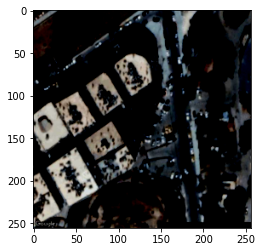

In [12]:
np_img = np.transpose(data.numpy(), (1, 2, 0))
plt.imshow(np.clip(np_img, 0, 1))
plt.show()

#### Helper functions

In [0]:
import torch.nn as nn

In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom deconvolutional layer """
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom convolutional layer"""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

# Batch norm True False (last layer)

Construction of the two discriminators 

In [0]:
class D_DESTROYED(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=32):
        super(D_DESTROYED, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, conv_dim*16, 4)
        self.conv6 = conv(conv_dim*16, conv_dim*32, 4)
        self.fc = conv(conv_dim*32, 1, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = F.leaky_relu(self.conv4(out), 0.05)  # (?, 256, 4, 4)
        out = F.leaky_relu(self.conv5(out), 0.05)  # (?, 256, 4, 4)
        out = F.leaky_relu(self.conv6(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

class D_UNDAMAGED(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=64):
        super(D_UNDAMAGED, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, conv_dim*16, 4)
        self.conv6 = conv(conv_dim*16, conv_dim*32, 4)
        self.fc = conv(conv_dim*32, 1, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = F.leaky_relu(self.conv4(out), 0.05)  # (?, 256, 4, 4)
        out = F.leaky_relu(self.conv5(out), 0.05)  # (?, 256, 4, 4)
        out = F.leaky_relu(self.conv6(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out


Creating the two generators 

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [0]:
class G_D_U(nn.Module):
    """Generator for transfering from mnist to usps"""
    def __init__(self, conv_dim=32):
        super(G_D_U, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, conv_dim*16, 4)
        self.conv6 = conv(conv_dim*16, conv_dim*32, 4)

        # residual blocks
        self.conv7 = conv(conv_dim*32, conv_dim*32, 3, 1, 1)
        self.conv8 = conv(conv_dim*32, conv_dim*32, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out

class G_U_D(nn.Module):
    """Generator for transfering from usps to mnist"""
    def __init__(self, conv_dim=64):
        super(G_U_D, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        return out


Building model 

In [0]:
def print_models(G_DtoU, G_UtoD, D_D, D_U):
    """Prints model information for the generators and discriminators.
    """
    print("                 G_MtoU                ")
    print("---------------------------------------")
    print(G_DtoU)
    print("---------------------------------------")

    print("                 G_UtoM                ")
    print("---------------------------------------")
    print(G_UtoD)
    print("---------------------------------------")

    print("                  D_M                  ")
    print("---------------------------------------")
    print(D_D)
    print("---------------------------------------")

    print("                  D_U                  ")
    print("---------------------------------------")
    print(D_U)
    print("---------------------------------------")

In [0]:
def create_model():
  G_DtoU = Generator(input_nc=3,output_nc=3)
  G_UtoD = Generator(input_nc=3,output_nc=3)
  D_D = D_DESTROYED()
  D_U = D_UNDAMAGED()

  print_models(G_DtoU, G_UtoD, D_D, D_U)

  if torch.cuda.is_available():
      G_DtoU.cuda()
      G_UtoD.cuda()
      D_D.cuda()
      D_U.cuda()
      print('Models moved to GPU.')
  return G_DtoU,G_UtoD, D_D, D_U

In [0]:
def save_samples(iteration, fixed_U, fixed_D, G_UtoD, G_DtoU):
    """Saves samples from both generators M->U and U->M.
    """
    import os
    import imageio
    fake_D = G_UtoD(fixed_U)
    fake_U = G_DtoU(fixed_D)

    D, fake_D = to_data(fixed_D), to_data(fake_D)
    U, fake_U = to_data(fixed_U), to_data(fake_U)

    merged = merge_images(D, fake_U)
    path = os.path.join('/content/', 'sample-{:06d}-D-U.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(U, fake_D)
    path = os.path.join('/content/', 'sample-{:06d}-U-D.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [0]:
def merge_images(sources, targets, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    row = int(np.sqrt(64))
    merged = np.zeros([3, row*h, row*w*2]) # 3
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)

Helper functions 

In [0]:
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

### Training loop

In [23]:
# Check number of parameters in the generator
pytorch_total_params = sum(p.numel() for p in G_D_U().parameters())
pytorch_total_params

30091264

In [24]:
[torch.std(p).item() for p in G_D_U().parameters()]

[0.08325862139463425,
 0.0,
 0.0,
 0.025585325434803963,
 0.0,
 0.0,
 0.018024373799562454,
 0.0,
 0.0,
 0.012760658748447895,
 0.0,
 0.0,
 0.009022146463394165,
 0.0,
 0.0,
 0.006379848346114159,
 0.0,
 0.0,
 0.006013990379869938,
 0.0,
 0.0,
 0.0060143726877868176,
 0.0,
 0.0,
 0.025439539924263954,
 0.0,
 0.0,
 0.14573587477207184]

In [25]:
G_DtoU, G_UtoD, D_D, D_U = create_model()

iter_D = iter(destroyed_loader)
iter_U = iter(undamaged_loader)


                 G_MtoU                
---------------------------------------
Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    

In [26]:
images_D = iter_D.next()
images_D = to_var(images_D)
images_D

tensor([[[[-0.3804, -0.2784, -0.0353,  ..., -0.0118, -0.0039, -0.0196],
          [-0.3020, -0.1765,  0.0745,  ..., -0.0275, -0.0039, -0.0275],
          [-0.3882, -0.0588,  0.2392,  ..., -0.0196, -0.0275, -0.0353],
          ...,
          [-0.9137, -0.8980, -0.8667,  ..., -0.0824, -0.0824, -0.5608],
          [-0.9294, -0.9216, -0.8824,  ..., -0.3412, -0.4353, -0.5686],
          [-0.9137, -0.9451, -0.9216,  ..., -0.5608, -0.5451, -0.5686]],

         [[-0.3804, -0.2627,  0.0039,  ...,  0.0431,  0.0510,  0.0353],
          [-0.3020, -0.1529,  0.1216,  ...,  0.0275,  0.0510,  0.0275],
          [-0.3882, -0.0431,  0.2863,  ...,  0.0353,  0.0275,  0.0196],
          ...,
          [-0.8980, -0.8824, -0.8431,  ..., -0.0824, -0.0824, -0.5608],
          [-0.9137, -0.9059, -0.8588,  ..., -0.3412, -0.4353, -0.5608],
          [-0.8902, -0.9216, -0.8980,  ..., -0.5608, -0.5451, -0.5608]],

         [[-0.4431, -0.2863,  0.0431,  ...,  0.1216,  0.1294,  0.1137],
          [-0.3647, -0.1765,  

In [0]:
# Compute the discriminator losses on real images
out_D = D_D(images_D) # discriminator mnist true
#D_M_loss = torch.mean((out_M-1)**2) 

In [28]:
out_D

tensor([-0.0440, -0.5957, -0.0278,  0.1356], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [0]:
gen_D = G_DtoU(images_D)

In [30]:
gen_D.size()

torch.Size([4, 3, 256, 256])

In [0]:
def training_loop(destroyed_loader, undamaged_loader, sample_every=1000,  lr=0.0002, train_iters=20000, log_step = 10, batch_size=4, use_cycle_consistency_loss=True):
  # Create generators and discriminators
  G_DtoU, G_UtoD, D_D, D_U = create_model()

  g_params = list(G_DtoU.parameters()) + list(G_UtoD.parameters())  # Get generator parameters
  d_params = list(D_D.parameters()) + list(D_U.parameters())  # Get discriminator parameters

  # Create optimizers for the generators and discriminators
  g_optimizer = optim.Adam(g_params, lr)
  d_optimizer = optim.Adam(d_params, lr)

  iter_D = iter(destroyed_loader)
  iter_U = iter(undamaged_loader)

  test_iter_D = iter(destroyed_loader)
  test_iter_U = iter(undamaged_loader)

  # Get some fixed data from domains X and Y for sampling. These are images that are held
  # constant throughout training, that allow us to inspect the model's performance.
  fixed_D = to_var(test_iter_D.next()[0])
  fixed_U = to_var(test_iter_U.next()[0])

  iter_per_epoch = min(len(iter_D), len(iter_U))

  for iteration in range(1, train_iters+1):

      # Reset data_iter for each epoch
      if iteration % iter_per_epoch == 0:
          iter_D = iter(destroyed_loader)
          iter_U = iter(undamaged_loader)

      images_D = iter_D.next()
      images_D = to_var(images_D)

      images_U = iter_U.next()
      images_U = to_var(images_U)

     # num_classes = 10

      #if use_labels:
      #  M_fake_labels = to_var(
       #     torch.Tensor([num_classes]*images_U.size(0)).long())
        #svhn_fake_labels = to_var(
         #   torch.Tensor([num_classes]*images_M.size(0)).long())


      # ============================================
      #            TRAIN THE DISCRIMINATORS
      # ============================================

       # Clipping discriminator parameters 
      for p in D_D.parameters():
            p.data.clamp_(-0.01, 0.01)

      # Train with real images
      d_optimizer.zero_grad()

      # Compute the discriminator losses on real images
      out_D = D_D(images_D) # discriminator mnist true
      D_D_loss = torch.mean((out_D-1)**2) 

      out_U = D_U(images_U)
      D_U_loss = torch.mean((out_U-1)**2)

      d_real_loss = D_D_loss + D_U_loss
      d_real_loss.backward()
      d_optimizer.step()

      # Train with fake images
      d_optimizer.zero_grad()

      # Generate fake images that look like domain MNIST based on real images in domain USPS
      fake_D = G_UtoD(images_U)

      # Compute the loss for D_M
      out_D = D_D(fake_D)
      D_D_loss = torch.mean(out_D**2) 

      # 4. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_DtoU(images_D)

      # 5. Compute the loss for D_U
      out_U = D_U(fake_U)
      D_U_loss = torch.mean((out_U)**2) 

      d_fake_loss = D_D_loss + D_U_loss
      d_fake_loss.backward()
      d_optimizer.step()

      # =========================================
      #            TRAIN THE GENERATORS
      # =========================================

      ## U--M-->U 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain M based on real images in domain U
      fake_D = G_UtoD(images_U)
      out = D_D(fake_D)

      # 2. Compute the generator loss based on domain M

      g_loss = torch.mean((out-1)**2)

      if use_cycle_consistency_loss:
          reconstructed_U = G_DtoU(fake_D)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()

      ## M--U-->M 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_DtoU(images_D)
      out = D_U(fake_U)

      # 2. Compute the generator loss based on domain U
      g_loss = torch.mean((out-1)**2)

      if use_cycle_consistency_loss:
          reconstructed_D = G_UtoD(fake_U)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_D - reconstructed_D)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()


      # Print the log info
      if iteration % log_step == 0:
          print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                  D_D_loss.item(), d_fake_loss.item(), g_loss.item()))


      # Save the generated samples
      if iteration % sample_every == 0:
          save_samples(iteration, fixed_U, fixed_D, G_UtoD, G_DtoU)

In [0]:
#training_loop(destroyed_loader,undamaged_loader, sample_every=1000,  lr=0.0002, train_iters=200, log_step = 10,  use_cycle_consistency_loss=True)

In [0]:
# images_U = iter_U.next()
# images_U = to_var(images_U)
# fake_D = G_UtoD(images_U)


In [0]:
# image= fake_D[0].detach().cpu().numpy()
# images_U = images_U[0].detach().cpu().numpy()

In [0]:
# image=np.transpose(image,(1,2,0))
# images_U=np.transpose(image,(1,2,0))

In [0]:
# image= np.clip(image,0,1)
# images_U=np.clip(images_U,0,1)

In [0]:
# plt.imshow(image)

In [0]:
# plt.imshow(images_U)

In [0]:
# from PIL import Image
# image = Image.open('/content/sample-005000-U-M.png')
# image

In [0]:
# from PIL import Image
# image = Image.open('/content/sample-005000-M-U.png')
# image

In [0]:
# training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=5000, log_step = 100,  use_cycle_consistency_loss=False)

In [0]:
# from PIL import Image
# image = Image.open('/content/sample-005000-U-M.png')
# image

# Testing Wassesrstein Cycle GAN 

What we need to modify : 
1. Turning the Adam optimizer into the RMS Prop optimizer 
2. The discriminator should not end with a sigmoid on the last layer (this is ok) 
3. D_loss =  -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))


G_loss = -torch.mean(D_fake)

4. Clip parameters 

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
def training_loop(destroyed_loader, undamaged_loader, sample_every=1000,  lr=0.0002, train_iters=20000, log_step = 10, batch_size=4, use_cycle_consistency_loss=True):
  # Create generators and discriminators
  G_DtoU, G_UtoD, D_D, D_U = create_model()

  G_DtoU.apply(weights_init)
  G_UtoD.apply(weights_init)
  D_D.apply(weights_init)
  D_U.apply(weights_init)

  g_params = list(G_DtoU.parameters()) + list(G_UtoD.parameters())  # Get generator parameters
  d_m_params = list(D_D.parameters())  # Get discriminator parameters
  d_u_params = list(D_U.parameters())  # Get discriminator parameters

  # Create optimizers for the generators and discriminators
  g_optimizer = optim.RMSprop(g_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
  d_m_optimizer = optim.RMSprop(d_m_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
  d_u_optimizer = optim.RMSprop(d_u_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

  iter_D = iter(destroyed_loader)
  iter_U = iter(undamaged_loader)

  test_iter_D = iter(destroyed_loader)
  test_iter_U = iter(undamaged_loader)

  fixed_D = to_var(test_iter_D.next()[0])
  fixed_U = to_var(test_iter_U.next()[0])

  iter_per_epoch = min(len(iter_D), len(iter_U))

  for iteration in range(1, train_iters+1):

      # Reset data_iter for each epoch
      if iteration % iter_per_epoch == 0:
          iter_D = iter(destroyed_loader)
          iter_U = iter(undamaged_loader)

      images_D = iter_D.next()
      images_D = to_var(images_D)

      images_U = iter_U.next()
      images_U = to_var(images_U)

      # ============================================
      #            TRAIN THE DISCRIDINATORS
      # ============================================

      for _ in range(5):
        # Train with real images
        d_m_optimizer.zero_grad()
        d_u_optimizer.zero_grad()

        # Compute the discriminator losses on real images
        out_D = D_D(images_D) # discriminator mnist true
        D_D_loss = - torch.mean(out_D) 

        out_U = D_U(images_U)
        D_U_loss = - torch.mean(out_U)

        d_real_loss = D_D_loss + D_U_loss
        d_real_loss_m = D_D_loss
        d_real_loss_u = D_U_loss
        #d_real_loss.backward()
        #d_optimizer.step()

        # Train with fake images
        #d_optimizer.zero_grad()

        # Generate fake images that look like domain MNIST based on real images in domain USPS
        fake_D = G_UtoD(images_U)

        # Compute the loss for D_D
        out_D = D_D(fake_D)
        D_D_loss =  torch.mean(out_D) 

        # 4. Generate fake images that look like domain U based on real images in domain M
        fake_U = G_DtoU(images_D)

        # 5. Compute the loss for D_U
        out_U = D_U(fake_U)
        D_U_loss = torch.mean(out_U) 

        d_fake_loss = D_D_loss + D_U_loss

        d_loss = d_real_loss + d_fake_loss

        d_fake_loss_m = D_D_loss
        d_fake_loss_u = D_U_loss

        d_loss_m = d_real_loss_m + d_fake_loss_m
        d_loss_u = d_real_loss_u + d_fake_loss_u

        d_loss_u.backward()
        d_loss_m.backward()

        d_m_optimizer.step()
        d_u_optimizer.step()

        #d_loss.backward()
        #d_optimizer.step()

        # Clipping discriminator parameters 
        for p in D_D.parameters():
              p.data.clamp_(-0.01, 0.01)
        
        # Clipping discriminator parameters 
        for p in D_U.parameters():
              p.data.clamp_(-0.01, 0.01)

      # =========================================
      #            TRAIN THE GENERATORS
      # =========================================

      ## U--D-->U 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain D based on real images in domain U
      fake_D = G_UtoD(images_U)
      out = D_D(fake_D)

      # 2. Compute the generator loss based on domain D

      g_loss = - torch.mean(out)

      if use_cycle_consistency_loss:
          reconstructed_U = G_DtoU(fake_D)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
          g_loss += cycle_consistency_loss

      #g_loss.backward()
      #g_optimizer.step()

      ## D--U-->D 

      #torch.mean((D_D(G_UtoD(images_U)-1)**2) + torch.mean((images_U - G_DtoU(G_UtoD(images_U)))**2)

      #g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain U based on real images in domain D
      fake_U = G_DtoU(images_D)
      out = D_U(fake_U)

      # 2. Compute the generator loss based on domain U
      #g_loss = - torch.mean(out)
      g_loss += - torch.mean(out)

      if use_cycle_consistency_loss:
          reconstructed_D = G_UtoD(fake_U)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_D - reconstructed_D)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()


      # Print the log info
      if iteration % log_step == 0:
          print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_D_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                  D_D_loss.item(), d_fake_loss.item(), g_loss.item()))


      # Save the generated samples
      if iteration % sample_every == 0:
          save_samples(iteration, fixed_U, fixed_D, G_UtoD, G_DtoU)

In [44]:
training_loop(destroyed_loader, undamaged_loader, sample_every=1000,  lr=0.0002, train_iters=200, log_step = 10,  use_cycle_consistency_loss=True)

                 G_MtoU                
---------------------------------------
Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    

RuntimeError: ignored

# Test on satellite imagery 


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../data/images/ezzor'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes